In [1]:
import torch
import torch_directml
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import time # for measuring time
%matplotlib inline

In [2]:
device = 'cpu'
print(device)

cpu


In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words = [word.lower() for word in words]

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, Y.shape

(torch.Size([8752, 3]), torch.Size([8752]))

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([6983, 3]) torch.Size([6983])
torch.Size([887, 3]) torch.Size([887])
torch.Size([882, 3]) torch.Size([882])


In [8]:
C = torch.randn(27, 2)

In [9]:
emb = C[X]
print(emb.shape)

torch.Size([8752, 3, 2])


In [10]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2

In [14]:
count = logits.exp()
prob = count / count.sum(1, keepdim=True)

In [15]:
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()

# ------------ now made respectable :) ---------------

In [40]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g,).to(device)
W1 = torch.randn((6, 80), generator=g,).to(device) 
b1 = torch.randn(80, generator=g,).to(device) 
W2 = torch.randn((80, 27), generator=g,).to(device)
b2 = torch.randn(27, generator=g,).to(device)
parameters = [C, W1, b1, W2, b2]

In [41]:
sum(p.nelement() for p in parameters) # number of parameters in total

2801

In [42]:
for p in parameters:
  p.requires_grad = True

In [19]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
lri = []
lossi = []
stepi = []

In [43]:
# start_time = time.time()

for i in range(200000):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,)).to(device)

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.2 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    print(i, loss.item(), end='\r')
    break

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

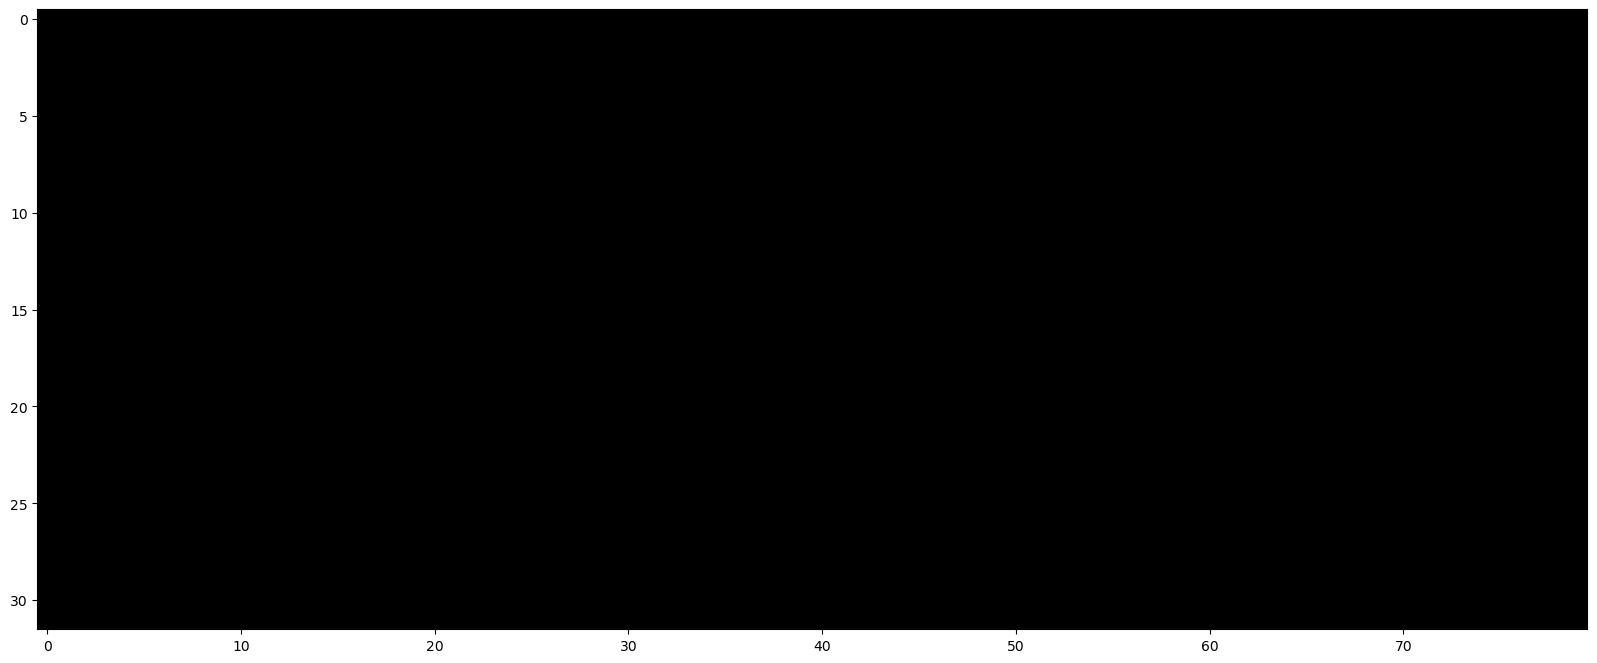

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray',interpolation='nearest')

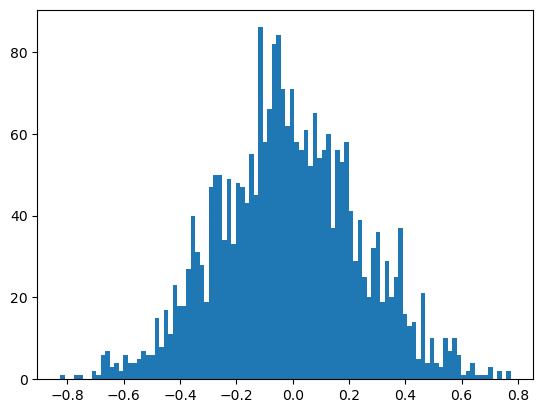

In [39]:
plt.hist(h.view(-1).tolist(), bins=100);

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))